# Import required Library 

In [1]:
from pandas_datareader import data
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
#from matplotlib.finance import candlestick_ohlc as candlestick
from mplfinance.original_flavor import candlestick_ohlc as candlestick # pls install matplotlib for candle stick plot 
import datetime
import requests

# Download Market Data

In [2]:
ticker = '5099.kl'
# Last 3 years closing prices starting from Jan 2, 2018.
 
now = datetime.datetime.now()
startyear = 2018
startmonth = 1 
startday = 1
start = datetime.datetime(startyear, startmonth, startday)
sec_id = pdr.get_data_yahoo(ticker, start, now)
sec_id.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-22,1.04,0.995,1.03,1.030,26030000.0,1.030
2021-11-23,1.02,0.995,1.00,1.000,31888000.0,1.000
2021-11-24,1.02,0.995,1.00,1.010,16512800.0,1.010
2021-11-25,1.01,0.950,1.00,0.965,17859100.0,0.965
2021-11-26,0.96,0.900,0.96,0.905,38802000.0,0.905


# Create technical Indicator

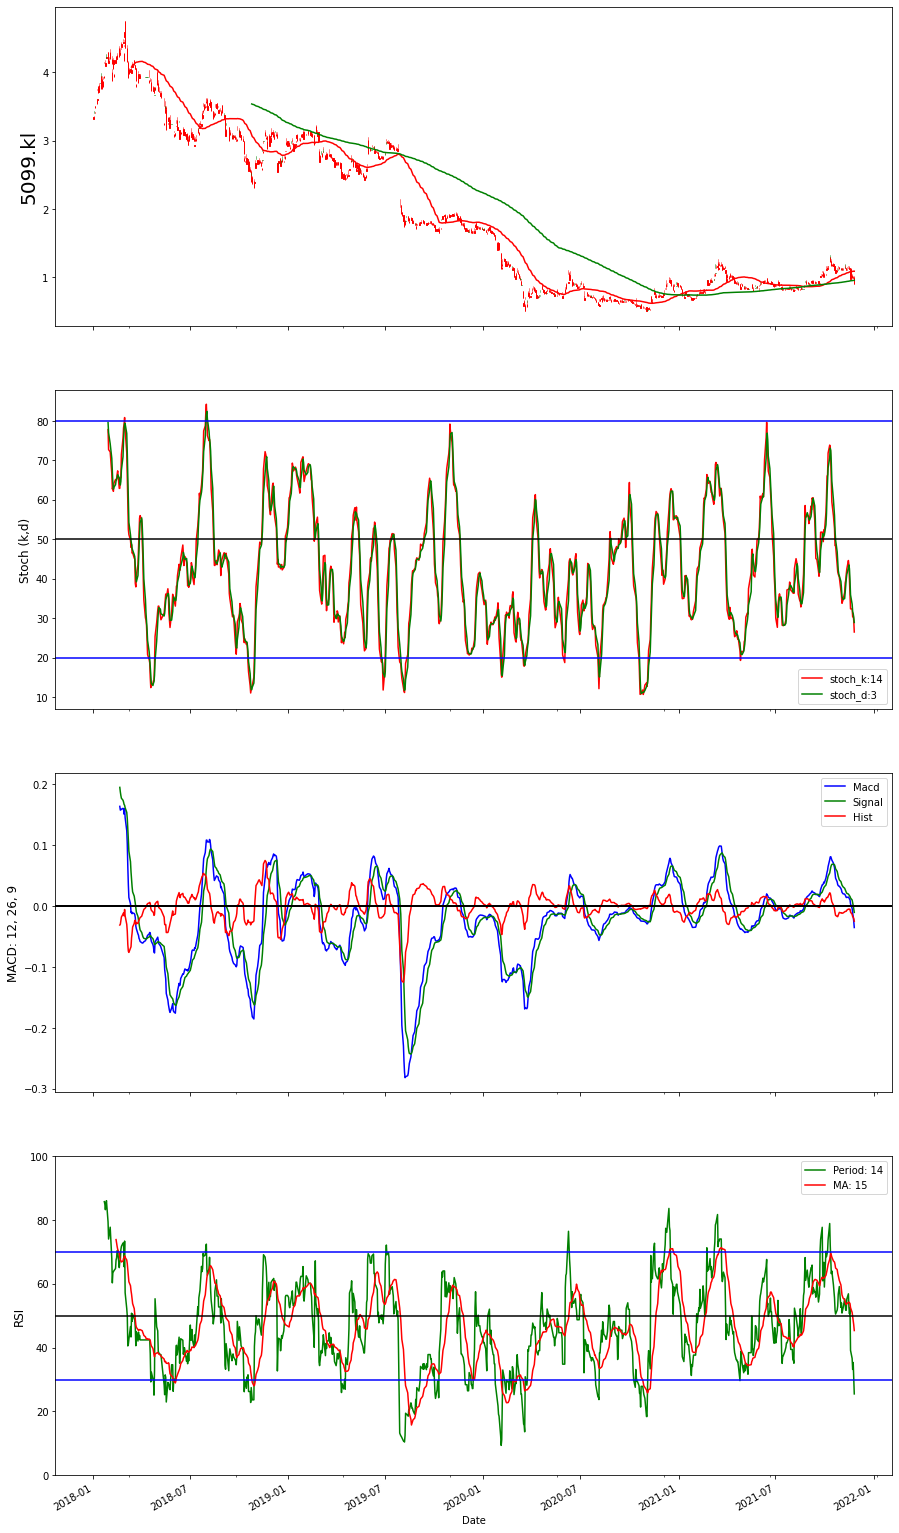

In [3]:

#ticker = 'OPK'

# Download sample data
#sec_id = data.get_data_yahoo(ticker, '2014-06-01')

# Data for matplotlib finance plot
sec_id_ochl = np.array(pd.DataFrame({'0':date2num(sec_id.index.to_pydatetime()),
                                  '1':sec_id.Open,
                                  '2':sec_id.Close,
                                  '3':sec_id.High,
                                  '4':sec_id.Low}))

# Technical Analysis
SMA_FAST = 50
SMA_SLOW = 200
RSI_PERIOD = 14
RSI_AVG_PERIOD = 15
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9
STOCH_K = 14
STOCH_D = 3
SIGNAL_TOL = 3
Y_AXIS_SIZE = 12

analysis = pd.DataFrame(index = sec_id.index)

#analysis['sma_f'] = pd.rolling_mean(sec_id.Close, SMA_FAST)
analysis['sma_f'] = sec_id.Close.rolling(SMA_FAST).mean()

#analysis['sma_s'] = pd.rolling_mean(sec_id.Close, SMA_SLOW)
analysis['sma_s'] = sec_id.Close.rolling(SMA_SLOW).mean()
#analysis['rsi'] = ta.RSI(sec_id.Close.as_matrix(), RSI_PERIOD)
analysis['rsi'] = ta.RSI(sec_id.Close.to_numpy(), RSI_PERIOD)
#analysis['sma_r'] = pd.rolling_mean(analysis.rsi, RSI_AVG_PERIOD) # check shift
analysis['sma_r'] = analysis.rsi.rolling(RSI_AVG_PERIOD).mean() # check shift

#analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(sec_id.Close.as_matrix(), fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(sec_id.Close.to_numpy(), fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
#analysis['stoch_k'], analysis['stoch_d'] = ta.STOCH(sec_id.High.as_matrix(), sec_id.Low.as_matrix(), sec_id.Close.as_matrix(), slowk_period=STOCH_K, slowd_period=STOCH_D)
analysis['stoch_k'], analysis['stoch_d'] = ta.STOCH(sec_id.High.to_numpy(), sec_id.Low.to_numpy(), sec_id.Close.to_numpy(), slowk_period=STOCH_K, slowd_period=STOCH_D)

analysis['sma'] = np.where(analysis.sma_f > analysis.sma_s, 1, 0)
analysis['macd_test'] = np.where((analysis.macd > analysis.macdSignal), 1, 0)
analysis['stoch_k_test'] = np.where((analysis.stoch_k < 50) & (analysis.stoch_k > analysis.stoch_k.shift(1)), 1, 0)
analysis['rsi_test'] = np.where((analysis.rsi < 50) & (analysis.rsi > analysis.rsi.shift(1)), 1, 0)
analysis[['Open','Close','High','Low']]= sec_id[['Open','Close','High','Low']]

# Prepare plot
fig, (ax1, ax4, ax3, ax2) = plt.subplots(4, 1, sharex=True)
ax1.set_ylabel(ticker, size=20)

#size plot
fig.set_size_inches(15,30)

# Plot candles
candlestick(ax1, sec_id_ochl, width=0.5, colorup='g', colordown='r', alpha=1)

# Draw Moving Averages
analysis.sma_f.plot(ax=ax1, c='r')
analysis.sma_s.plot(ax=ax1, c='g')

#RSI
ax2.set_ylabel('RSI', size=Y_AXIS_SIZE)
analysis.rsi.plot(ax = ax2, c='g', label = 'Period: ' + str(RSI_PERIOD))
analysis.sma_r.plot(ax = ax2, c='r', label = 'MA: ' + str(RSI_AVG_PERIOD))
ax2.axhline(y=30, c='b')
ax2.axhline(y=50, c='black')
ax2.axhline(y=70, c='b')
ax2.set_ylim([0,100])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)

# Draw MACD computed with Talib
ax3.set_ylabel('MACD: '+ str(MACD_FAST) + ', ' + str(MACD_SLOW) + ', ' + str(MACD_SIGNAL), size=Y_AXIS_SIZE)
analysis.macd.plot(ax=ax3, color='b', label='Macd')
analysis.macdSignal.plot(ax=ax3, color='g', label='Signal')
analysis.macdHist.plot(ax=ax3, color='r', label='Hist')
ax3.axhline(0, lw=2, color='0')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels)

# Stochastic plot
ax4.set_ylabel('Stoch (k,d)', size=Y_AXIS_SIZE)
analysis.stoch_k.plot(ax=ax4, label='stoch_k:'+ str(STOCH_K), color='r')
analysis.stoch_d.plot(ax=ax4, label='stoch_d:'+ str(STOCH_D), color='g')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels)
ax4.axhline(y=20, c='b')
ax4.axhline(y=50, c='black')
ax4.axhline(y=80, c='b')

plt.show()

In [4]:
analysis.sort_index(inplace= True)

analysis.head(10)

,sma_f,sma_s,rsi,sma_r,macd,macdSignal,macdHist,stoch_k,stoch_d,sma,macd_test,stoch_k_test,rsi_test,Open,Close,High,Low
Date,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.35,3.34,3.36,3.31
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.34,3.41,3.44,3.34
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.42,3.49,3.50,3.41
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.50,3.59,3.59,3.48
2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.59,3.59,3.60,3.54
2018-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.61,3.74,3.76,3.60
2018-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.75,3.78,3.80,3.70
2018-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.78,3.77,3.80,3.71
2018-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,3.81,3.82,3.85,3.78


# Buy and Sell position

## Buy Position

In [5]:
analysis['macdHist_shift'] = analysis['macdHist'].shift(1)

In [6]:
cond_buy = [
    (analysis['macdHist_shift'] <  0) & (analysis['macdHist'] >  0) & (analysis['macd'] < -0.02),
    ]
values_buy = [analysis['Close']]
values_BuySignal = ['Buy']

analysis['Buy_Price'] = np.select(cond_buy, values_buy,np.nan)
analysis['BuySell_Signal'] = np.select(cond_buy, values_BuySignal,' ')


## Sell Position

In [7]:
TargetSell = np.nan
StopLoss = np.nan
analysis['Sell_Price'] = np.nan
for i in analysis.index:
    if analysis['Buy_Price'][i] > 0:
        BuyPrice = analysis['Buy_Price'][i]
        print('Buy Price  ++ ',BuyPrice)
        TargetSell = BuyPrice * 1.03
        StopLoss = BuyPrice * -1.04
        print('Target profit 2%', TargetSell)
    print('Close Price == ', analysis['Close'][i])
    if (analysis['Close'][i] > TargetSell) & (TargetSell != np.nan):
        SellPrice = analysis['Close'][i]
        print('Sell Price *** ', SellPrice)
        TargetSell = np.nan
        analysis['Sell_Price'][i] = analysis['Close'][i]
        analysis['BuySell_Signal'][i] = 'Sell'
    elif (analysis['Close'][i] < StopLoss) & (TargetSell != np.nan):
        SellPrice = analysis['Close'][i]
        analysis['BuySell_Signal'][i] = 'Sell'
        print('Sell Price losssssss *** ', SellPrice)
        TargetSell = np.nan
        #analysis['Buy_signal'][i] = analysis['Close'][i]
        

Close Price ==  3.3399999141693115
Close Price ==  3.4100000858306885
Close Price ==  3.490000009536743
Close Price ==  3.5899999141693115
Close Price ==  3.5899999141693115
Close Price ==  3.740000009536743
Close Price ==  3.7799999713897705
Close Price ==  3.7699999809265137
Close Price ==  3.819999933242798
Close Price ==  3.930000066757202
Close Price ==  3.8299999237060547
Close Price ==  3.9000000953674316
Close Price ==  3.8499999046325684
Close Price ==  3.9000000953674316
Close Price ==  4.139999866485596
Close Price ==  4.130000114440918
Close Price ==  4.110000133514404
Close Price ==  4.210000038146973
Close Price ==  4.289999961853027
Close Price ==  4.210000038146973
Close Price ==  4.139999866485596
Close Price ==  4.300000190734863
Close Price ==  4.150000095367432
Close Price ==  4.010000228881836
Close Price ==  4.110000133514404
Close Price ==  4.119999885559082
Close Price ==  4.130000114440918
Close Price ==  4.150000095367432
Close Price ==  4.230000019073486
Clos

<ipython-input-7-da1f0baf8f1b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['Sell_Price'][i] = analysis['Close'][i]
<ipython-input-7-da1f0baf8f1b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['BuySell_Signal'][i] = 'Sell'



Close Price ==  0.9150000214576721
Close Price ==  0.9350000023841858
Close Price ==  0.9150000214576721
Close Price ==  0.9200000166893005
Close Price ==  0.925000011920929
Close Price ==  1.0
Close Price ==  1.0299999713897705
Close Price ==  1.0700000524520874
Close Price ==  1.0
Close Price ==  1.0199999809265137
Close Price ==  1.0499999523162842
Close Price ==  1.0099999904632568
Close Price ==  1.1299999952316284
Close Price ==  1.1200000047683716
Close Price ==  1.1299999952316284
Close Price ==  1.1399999856948853
Close Price ==  1.190000057220459
Close Price ==  1.2799999713897705
Close Price ==  1.2400000095367432
Close Price ==  1.2100000381469727
Close Price ==  1.1799999475479126
Close Price ==  1.190000057220459
Close Price ==  1.159999966621399
Close Price ==  1.1299999952316284
Close Price ==  1.100000023841858
Close Price ==  1.090000033378601
Close Price ==  1.100000023841858
Close Price ==  1.1100000143051147
Close Price ==  1.1399999856948853
Close Price ==  1.149

In [8]:
#analysis ['BuySell_signal'] = np.where(((analysis['macdHist_shift'] <  0) & (analysis['macdHist'] >  0)), 'Buy',(np.where(((analysis['macdHist_shift'] >  0) & (analysis['macdHist'] <  0)),'Sell',np.nan)))

In [9]:
#df_buy = analysis[(analysis['BuySell_signal'] == 'Buy') | (analysis['BuySell_signal'] == 'Sell')]
#df_buy['BuySell_signal'][0]== "Buy"
#
#df_buy['BuySell_signal'][0]== "Buy"

# Calculate Profit

In [10]:
df_buysell = analysis[(analysis['BuySell_signal'] == 'Buy') | (analysis['BuySell_signal'] == 'Sell')]
if df_buysell['BuySell_signal'][0]== "Sell" :
    df_buysell.drop(df_buysell.index[0] ,axis= 0 , inplace = True)
df_buysell_pivot = df_buysell[['Close','BuySell_signal']].reset_index()

KeyError: 'BuySell_signal'

In [ ]:
df_buysell_pivot['Profit']= np.nan
for x in range(0,len(df_buysell_pivot),2):
    df_buysell_pivot['Profit'][x+1] = df_buysell_pivot['Close'][x+1] - df_buysell_pivot['Close'][x] 

<ipython-input-98-fe2734e7bdb3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buysell_pivot['Profit'][x+1] = df_buysell_pivot['Close'][x+1] - df_buysell_pivot['Close'][x]


In [ ]:
df_buysell_pivot['Profit'].sum()

-0.1100001335144043

In [ ]:
df_buysell_pivot

,Date,Close,BuySell_signal,Profit
0,2021-03-22,2.75,Buy,NaN
1,2021-04-19,2.73,Sell,-0.02
2,2021-05-24,2.08,Buy,NaN
3,2021-07-12,2.20,Sell,0.12
4,2021-07-27,2.27,Buy,NaN
5,2021-07-28,2.12,Sell,-0.15
6,2021-09-06,2.14,Buy,NaN
7,2021-09-30,2.06,Sell,-0.08
8,2021-10-20,2.07,Buy,NaN
9,2021-11-11,2.09,Sell,0.02
